### Импорт библиотек

In [1]:
# импортируем необходимые библиотеки
from pandas import Series
import pandas as pd
import numpy as np

import math
import collections

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Функции

In [2]:
def outliers_iqr(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    return lower, upper, iqr

# визуальзация числовых признаков и выбросы
def visual_num(data, col, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle(
        'Гисторгамма и boxplot для {0} по default'.format(col), fontsize=20)
    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8)
    g2.boxplot([data[data.default == 0][col], data[data.default == 1][col]])
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.xticks([1, 2], ["0", "1"])
    plt.show


def outliers(data, col):
    l, r, iqr = outliers_iqr(data[col])

    out = (data[col] > r).sum() + (data[col] < l).sum()
    out_percent = round(
        out/data[col].count()*100, 1
    )

    print(f'----------------> {col} <----------------')
    print(f'IQR: {iqr}, границы выбросов: [{l}, {r}]')
    print(f'Всего {out} ({out_percent}%) выбросов')


# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']

# Добавляем метрики в общую таблицу
def summary_metrics(summary, col, y_valid, y_pred, y_pred_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(
        y_valid, y_pred), f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary


# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# визуализация confusion matrix
def conf_mat(y_valid, y_pred):
    cm = confusion_matrix(y_valid, y_pred)

    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()
    
def combining_types_adr(row):
    """Функция объединения признаков home_address и work_address"""
    result = 10*row['home_address'] + row['work_address'] 
    return result
# В итоге полуаем двузначное число, где первая цифра будет показывать признак home_address, вторая - work_address 

### Загрузка и предварительный осмотр данных

In [3]:
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'
#train = pd.read_csv(PATH_to_file + 'train.csv')
#test = pd.read_csv(PATH_to_file + 'test.csv')
#sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [6]:
# Для контроля зафиксируем размер тренировочного и тестового датасетов.
print('Размер тренировочного датасета: ', df_train.shape,
      'Размер тестового датасета: ', df_test.shape, 
      'Размер объединенного датасета: ', df_train.shape[0]+df_test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 18)
Размер объединенного датасета: 
110148


#### Описания полей датасета

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
score_bki - скоринговый балл по данным из БКИ
region_rating - рейтинг региона
app_date - дата подачи заявки
default - флаг дефолта по кредиту

### Общая информация о полях

In [7]:
# Объединяем тренировочные и тестовые данные в один датасет для того, чтобы все монипуляции с признаками проводить
# на обоих датасетах
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
# Проводим быстрый EDA c помощью pandas_profiling:

#pandas_profiling.ProfileReport(df)

Из отчета видно что пропуски присутствуют только в колонке education. Выборка по целевой переменной несбалансирована. Количество дефолтных клиентов в 6 раз больше чем не дефолтных. По heatmap видно, что больше всего коррелируют между собой признаки: first_time и sna, work_address и home_address.

### Работа с пропусками

In [10]:
df_train.isnull().sum(), df_test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

#### Пропуски только в education и их мало. Заполним их наиболее частыми значениями

In [11]:
# Заполним пропуски наиболее часто встречающимися данными:

df_train.education.fillna(
    df_train.education.mode()[0],
    inplace=True
)
df_test.education.fillna(
    df_test.education.mode()[0],
    inplace=True
)

### Feature engineering

#### Посмотрим на app_date

In [12]:
# В столбце app_date переводим дату в подходящий вид:
df_train.app_date = pd.to_datetime(df_train.app_date)
df_test.app_date = pd.to_datetime(df_test.app_date)
df_train.app_date.head(2), df_test.app_date.head(2)

(0   2014-02-01
 1   2014-03-12
 Name: app_date, dtype: datetime64[ns],
 0   2014-03-22
 1   2014-01-24
 Name: app_date, dtype: datetime64[ns])

#### Сделаем новый признак - количество дней до сегодняшнего числа¶

In [13]:
# Посчитаем количество дней до даты конца наблюдений
df_train['days'] = (df_train.app_date.max() - df_train.app_date).dt.days
df_test['days'] = (df_test.app_date.max() - df_test.app_date).dt.days

#### Посмотрим на признаки work_address и home_address

Сушествует корреляция между признаками work_address и home_address. Обхединим их в один признак.

In [14]:
df_train['address'] = df_train.apply(lambda row: combining_types_adr(row), axis=1)
df_test['address'] = df_test.apply(lambda row: combining_types_adr(row), axis=1)

#### Разделим колонки по типам данным

In [15]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'address', 'sna', 'first_time', 'region_rating']
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

Посмотрим на целевую переменную

In [16]:
df_train['default'].value_counts(normalize=True, dropna=False)

0    0.873006
1    0.126994
Name: default, dtype: float64

Распределение неравномерное, недефолтных клиентов заметно больше. Произведем простейший oversampling посредством дублирования строк с дефолтом:

In [17]:
zeros = df_train[df_train['default'] == 0]
ones = df_train[df_train['default'] == 1]
default_new = int(len(zeros) / len(ones))
for i in range(default_new):
    df_train = df_train.append(ones).reset_index(drop=True)

#### Результат

In [18]:
df_train['default'].value_counts(normalize=True, dropna=False)

1    0.504526
0    0.495474
Name: default, dtype: float64

<AxesSubplot:xlabel='default', ylabel='count'>

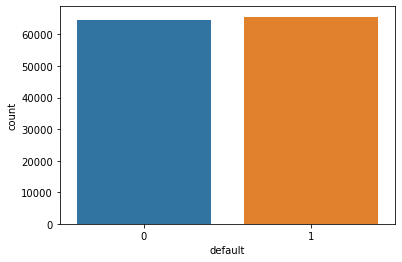

In [19]:
sns.countplot(x = df_train['default'], data = df_train)

### Смотрим на выбросы в числовых признаках

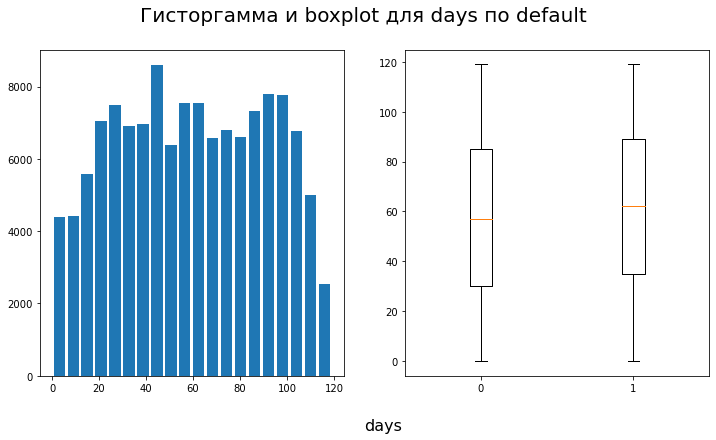

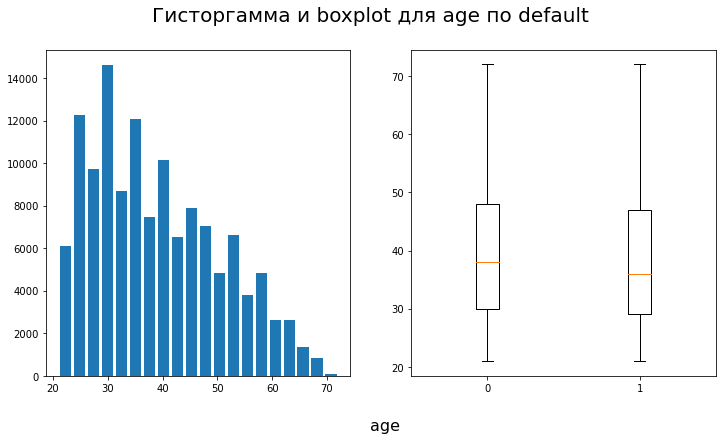

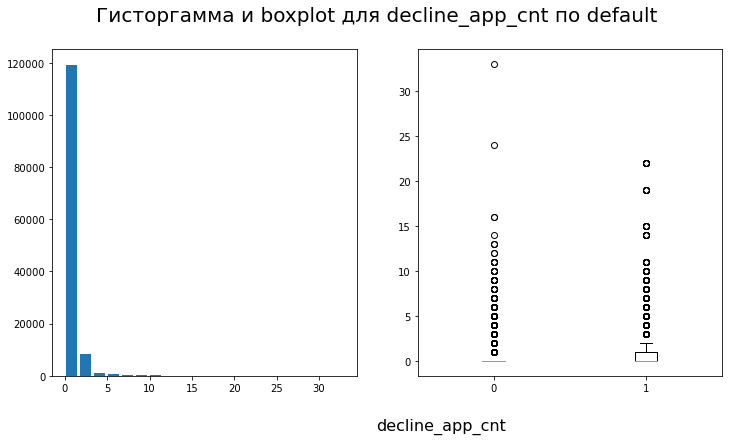

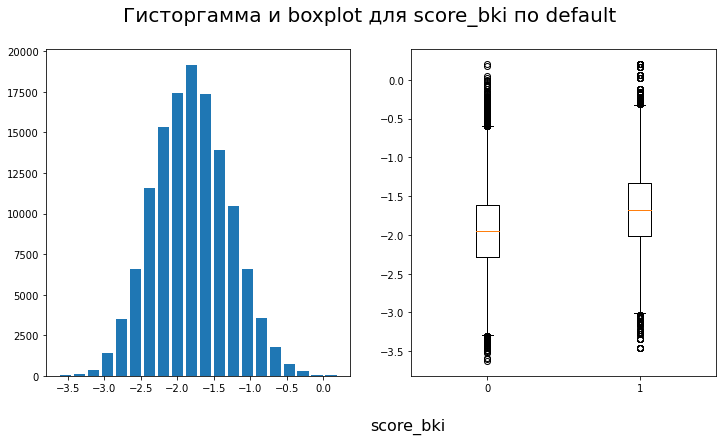

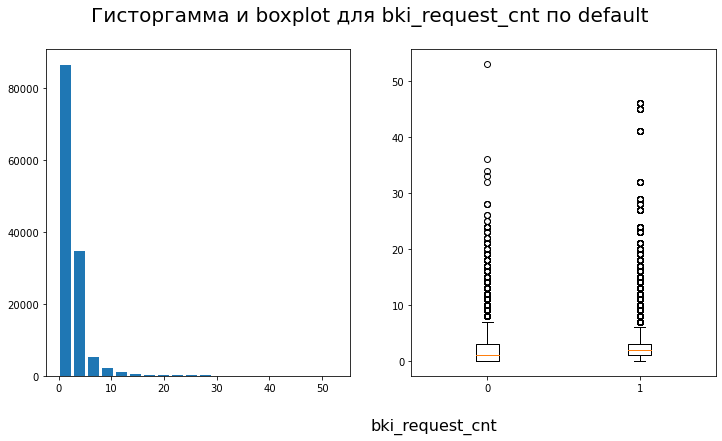

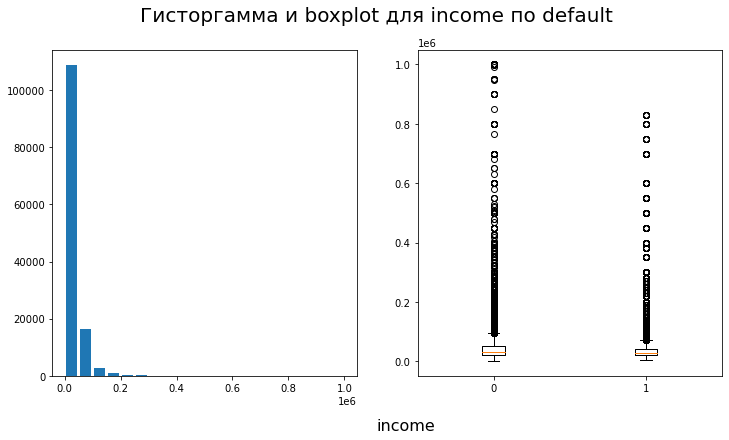

In [20]:
for col in num_cols:
    visual_num(df_train, col)

In [21]:
for col in num_cols:
    outliers(df_train, col)

----------------> days <----------------
IQR: 54.0, границы выбросов: [-48.0, 168.0]
Всего 0 (0.0%) выбросов
----------------> age <----------------
IQR: 18.0, границы выбросов: [2.0, 74.0]
Всего 0 (0.0%) выбросов
----------------> decline_app_cnt <----------------
IQR: 0.0, границы выбросов: [0.0, 0.0]
Всего 28587 (22.0%) выбросов
----------------> score_bki <----------------
IQR: 0.7081654850000001, границы выбросов: [-3.2317855925, -0.3991236524999999]
Всего 555 (0.4%) выбросов
----------------> bki_request_cnt <----------------
IQR: 2.0, границы выбросов: [-2.0, 6.0]
Всего 5715 (4.4%) выбросов
----------------> income <----------------
IQR: 25000.0, границы выбросов: [-17500.0, 82500.0]
Всего 8361 (6.4%) выбросов


У age и days выбросов нет, ничего не делаем.

У decline_app_cnt есть выбросы, но их удалять не нужно, т.к. медиана практически 0, после удаления весь этот признак обратится в 0 -- может плохо сказаться на модели.

У score_bki, bki_request_cnt и income есть выбросы, можно убрать.

In [22]:
# убираем выбросы в выбранных численных столбцах
num_cols_outliers = ['bki_request_cnt', 'score_bki', 'income']
for col in num_cols_outliers:
    d = outliers_iqr(df_train[col])
    df_train = df_train.loc[df_train[col].between(d[0], d[1])]

#### Прологарифмируем переменные, распределение которых смещено влево¶

In [23]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in num_cols_log:
    df_train[col] = np.log(df_train[col] + 1)

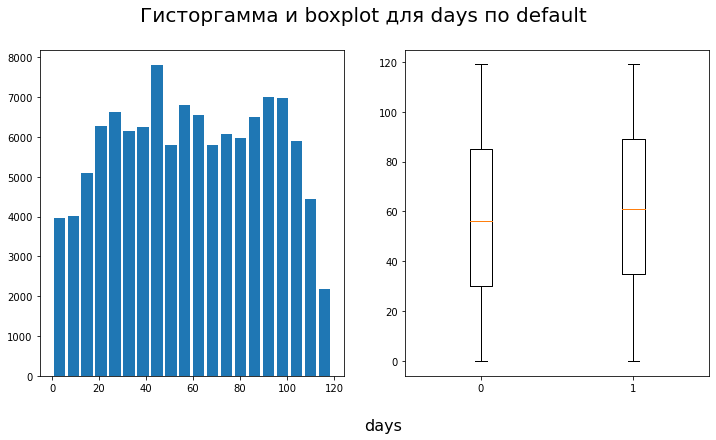

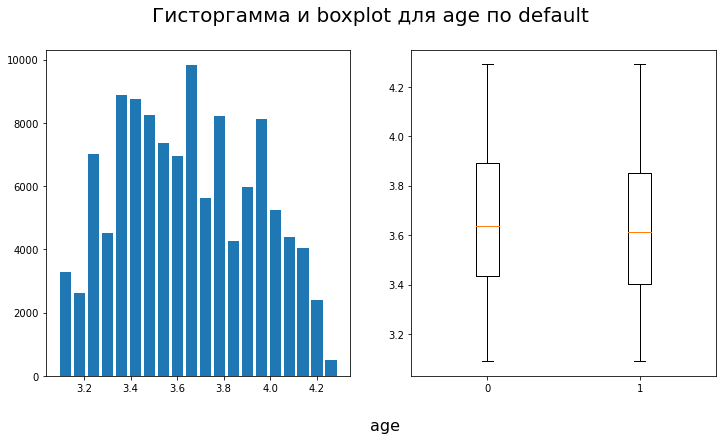

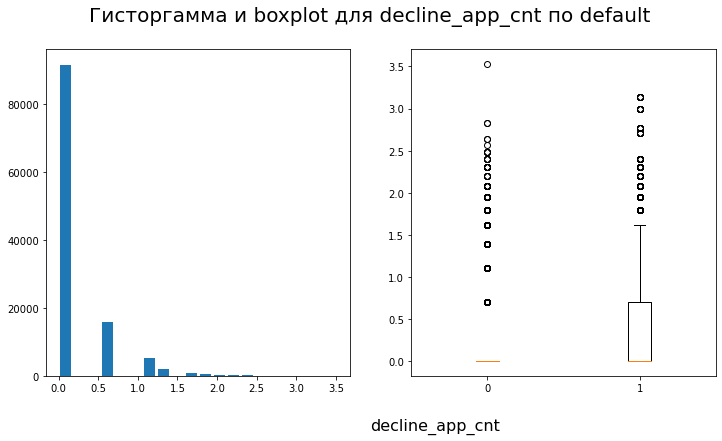

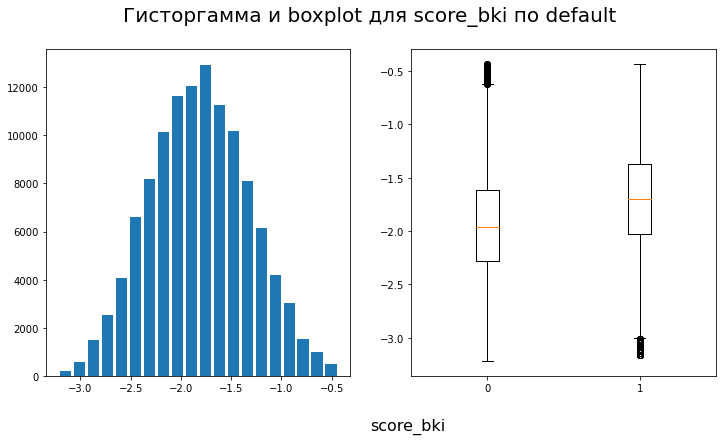

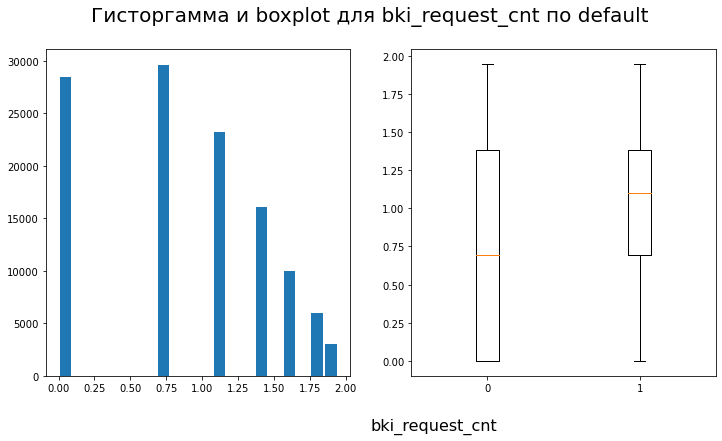

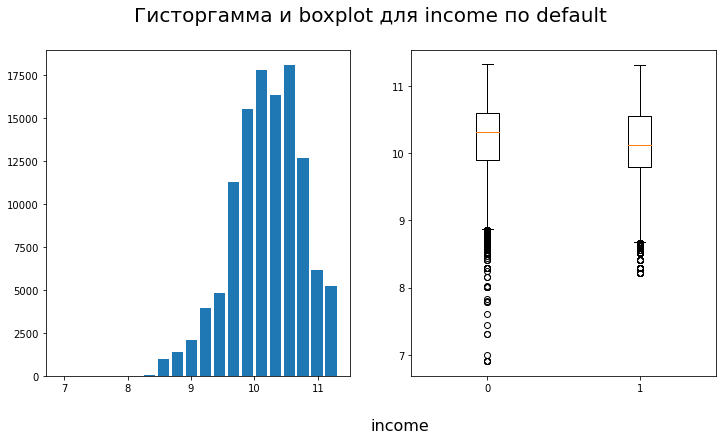

In [24]:
# результат
for col in num_cols:
    visual_num(df_train, col)

In [25]:
# Прологарифмируем так же для теста
for col in num_cols_log:
    df_test[col] = np.log(df_test[col] + 1)

In [26]:
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income
days,1.000,-0.021,0.020,0.058,-0.008,-0.007
age,-0.021,1.000,-0.153,-0.110,0.046,-0.159
decline_app_cnt,0.020,-0.153,1.000,0.213,0.077,0.007
score_bki,0.058,-0.110,0.213,1.000,0.105,0.001
bki_request_cnt,-0.008,0.046,0.077,0.105,1.000,0.054
income,-0.007,-0.159,0.007,0.001,0.054,1.000


#### Высокой корреляции между признаками не наблюдается

### Преобразование бинарных и категориальных переменных

In [27]:
# Преобразуем бинарные переменные при помощи класса LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

display(df_train.head())
#display(df_test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days,address
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,88,12
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,49,23
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,88,12
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,97,23
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,12,23


In [28]:
# Сделаем dummy из всех категориальных признаков
df_train = pd.get_dummies(df_train, columns=cat_cols)
df_test = pd.get_dummies(df_test, columns=cat_cols)

In [29]:
# Новый список категориальных признаков
cat_cols_dummies = [c1 for c in cat_cols for c1 in df_train.columns if c1.startswith(c)]

### Значимость непрерывных числовых признаков

Text(0.5, 0, 'F-value')

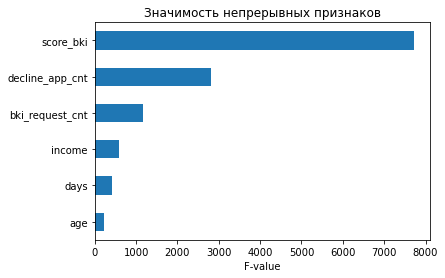

In [30]:
imp_num = Series(f_classif(df_train[num_cols], df_train.default)[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных признаков')
plt.xlabel('F-value')

### Значимость бинарных признаков

Text(0.5, 1.0, 'Значимость бинарных признаков')

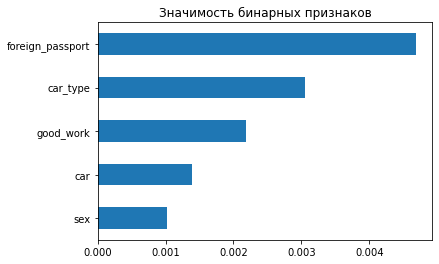

In [31]:
# Значимость бинарных признаков
imp_bin = Series(mutual_info_classif(df_train[bin_cols],
                                     df_train.default,
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

#### Значимость категориальных признаков

Text(0.5, 1.0, 'Значимость категориальных признаков')

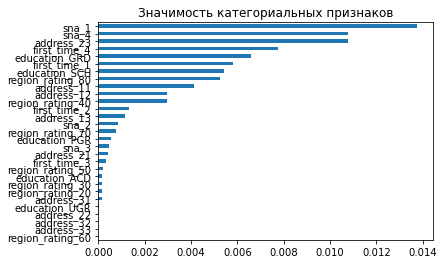

In [32]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols_dummies],
                                        df_train.default,
                                        discrete_features=True),
                    index=cat_cols_dummies)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных признаков')

### Подготовка данных к обучению

In [33]:
# Сгенерируем полиномальные признаки из числовых
poly = PolynomialFeatures(2)

x_poly_train = poly.fit_transform(df_train[num_cols].values)
x_poly_test = poly.fit_transform(df_test[num_cols].values)

In [34]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(x_poly_train)
X_num_test = StandardScaler().fit_transform(x_poly_test)

In [35]:
X_num_train.shape, X_num_test.shape

((116262, 28), (36349, 28))

### Объединим все в одно пространство

In [36]:
X = np.hstack([X_num_train, df_train[bin_cols].values, df_train[cat_cols_dummies].values])
Y = df_train.default.values

X_ids_test = np.hstack([X_num_test, df_test[bin_cols].values,  df_test[cat_cols_dummies].values])
ids_test = df_test.client_id

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    shuffle=True
)

In [38]:
# База с метриками
summary = pd.DataFrame(index=metrics)

### Первое обучение

In [39]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model.predict(X_valid)

In [41]:
y_pred_probs

array([0.53974712, 0.33991427, 0.43709942, ..., 0.21104996, 0.54115648,
       0.26533237])

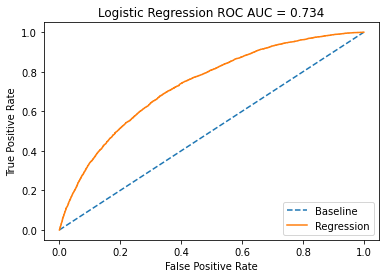

In [42]:
roc_auc_curve(y_valid, y_pred_probs)

In [43]:
summary_metrics(summary, 'model_1', y_valid, y_pred, y_pred_probs)

,model_1
accuracy,0.673418
precision,0.669062
recall,0.687801
f1_score,0.678302
ROC_AUC,0.733803


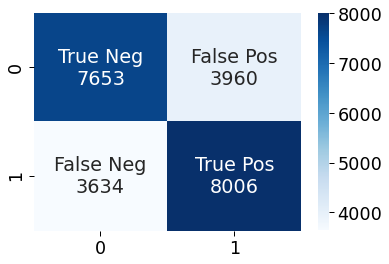

In [44]:
conf_mat(y_valid, y_pred)

### Подбор гиперпараметров (регуляризация)

In [45]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


### Обучение после регуляризации

In [46]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=2.7825594022071245, max_iter=1000)

In [47]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model.predict(X_valid)

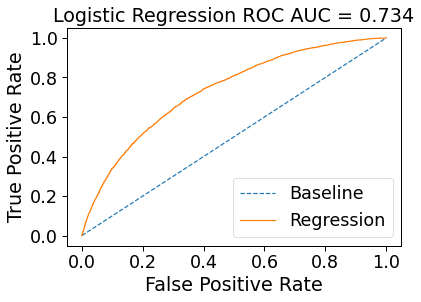

In [48]:
roc_auc_curve(y_valid, y_pred_probs)

In [49]:
summary_metrics(summary, 'model_2', y_valid, y_pred, y_pred_probs)

,model_1,model_2
accuracy,0.673418,0.673418
precision,0.669062,0.669147
recall,0.687801,0.687543
f1_score,0.678302,0.678220
ROC_AUC,0.733803,0.733816


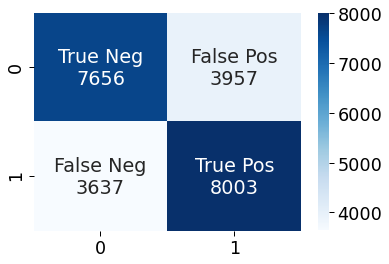

In [50]:
conf_mat(y_valid, y_pred)

Площадь под кривой немного выросла. Матрица ошибок показывает примерно тот же результат.

### Предсказываем и сохраняем submission

In [51]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X, Y)
probs = model.predict_proba(X_ids_test)
probs = probs[:, 1]

In [52]:
my_submission = pd.DataFrame({'client_id': ids_test,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.head(10)

,client_id,default
0,74835,0.247071
1,17527,0.730928
2,75683,0.370701
3,26883,0.406022
4,28862,0.176241
5,99881,0.589729
6,26630,0.781223
7,79934,0.206024
8,16605,0.104392
9,105449,0.143472
